In [1]:
import json
import os
from sympy import symbols, simplify, sin, expand
#from pysr import PySRRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

/home/paolo/.conda/envs/pymc_env/lib/python3.12/site-packages/numpy/_core/getlimits.py:552: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
import pymc as pm
import arviz as az

In [3]:
x = np.linspace(-2, 2, 500)
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
noise = rng.normal(size=x.shape)
y = np.cos(x) + noise 

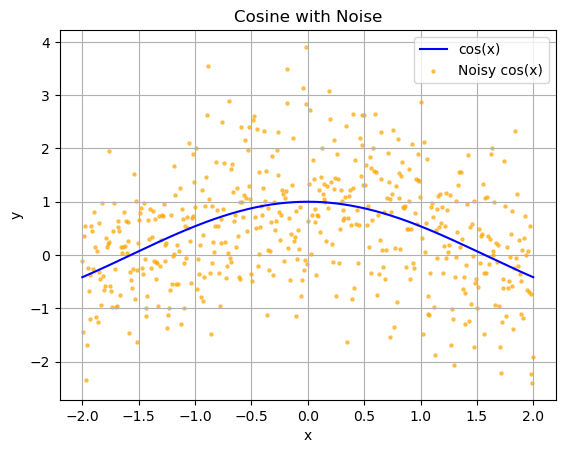

In [4]:
plt.plot(x, np.cos(x), label='cos(x)', color='blue')
plt.scatter(x, y, s=5, alpha=0.6, label='Noisy cos(x)', color='orange')
plt.legend()
plt.title('Cosine with Noise')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

In [6]:
# Save to CSV in a format SISSO++ expects
df = pd.DataFrame({"sample_id": [f"s{i+1}" for i in range(len(x))], 'f1': x, 'target': y})
df.to_csv("/home/paolo/Thesis/Test_uncertainty/data/cosine_data.csv", index=False)
data_file = "/home/paolo/Thesis/Test_uncertainty/data/cosine_data.csv"

os.environ["SISSOPP_TUT_DAT_FILE"] = data_file

In [ ]:
# Try the fit with the exact functional form
cos_json = {
    'data_file': data_file,
     'property_key': 'target',
     'desc_dim': 1,
     'n_sis_select': 10,
     'max_rung': 2,
     'calc_type': 'regression',
     'min_abs_feat_val': 1e-05,
     'max_abs_feat_val': 1e8,
     'n_residual': 10,
     'n_models_store': 10,
     'leave_out_frac': 0.0,
     'leave_out_inds': [],
     'opset': ['add', 'sub', 'mult', 'div', 'cos', 'sin', 'sqrt', 'sq']
}
json.dump(cos_json, open("/home/paolo/Thesis/Test_uncertainty/data/cos.json", "w"), indent=4)

In [ ]:
# # Try the fit with the exact functional form
# cos_json = {
#     'data_file': data_file,
#      'property_key': 'target',
#      'desc_dim': 1,
#      'n_sis_select': 10,
#      'max_rung': 2,
#      'calc_type': 'regression',
#      'min_abs_feat_val': 1e-05,
#      'max_abs_feat_val': 1e8,
#      'n_residual': 10,
#      'n_models_store': 10,
#      'leave_out_frac': 0.0,
#      'leave_out_inds': [],
#      'opset': ['add', 'sub', 'mult', 'div', 'cos', 'sin', 'sqrt', 'sq']
# }
# json.dump(cos_json, open("/home/paolo/Thesis/Test_uncertainty/data/cos.json", "w"), indent=4)

In [5]:
# Extract the formulas and the values of the parameters from the SISSO output
formulas = []
a0_list = []
c0_list = []
for i in range(10):
    filename = f'./models_cosine/train_dim_1_model_{i}.dat'
    with open(filename, 'r') as f:
        line1 = next(f)               # First line
        for _ in range(4): next(f)    # Skip lines 2 to 5
        line6 = next(f)               # Sixth line
        formula = line1.replace('#', '').strip()
        # Split line6 by spaces
        parts = line6.strip().split()
        a0_i = parts[3].rstrip(',')
        c0_i = parts[4].rstrip(',')

        formulas.append(formula)
        a0_list.append(a0_i)
        c0_list.append(c0_i)
        print(formula, a0_i, c0_i)

c0 + a0 * cos(f1) 1.026516626042362e+00 -2.513565483497359e-02
c0 + a0 * (sin(f1) / f1) 2.722430765680743e+00 -1.743636004010924e+00
c0 + a0 * (sin(f1) * f1) -7.192705739146151e-01 1.067479753468510e+00
c0 + a0 * (cos(f1) - (f1^2)) 2.777296467752327e-01 6.857838707456738e-01
c0 + a0 * (f1^2) -3.797943293052196e-01 9.482006102788901e-01
c0 + a0 * (cos(f1) + (f1^2)) -5.976215092714716e-01 1.510466509322255e+00
c0 + a0 * cos((f1^2)) 5.750589227309285e-01 3.081072596264779e-01
c0 + a0 * (sin(f1)^2) -1.167218004837731e+00 1.134346477826760e+00
c0 + a0 * ((f1^2)^2) -9.712679781678096e-02 7.530790459783490e-01
c0 + a0 * (sin(f1) - (f1^2)) 2.763907975739480e-01 8.097766439532607e-01


In [6]:
# Store the numerical values of the parameters into np arrays
a0 = np.array(a0_list, dtype=float)
c0 = np.array(c0_list, dtype=float)
a0, c0

(array([ 1.02651663,  2.72243077, -0.71927057,  0.27772965, -0.37979433,
        -0.59762151,  0.57505892, -1.167218  , -0.0971268 ,  0.2763908 ]),
 array([-0.02513565, -1.743636  ,  1.06747975,  0.68578387,  0.94820061,
         1.51046651,  0.30810726,  1.13434648,  0.75307905,  0.80977664]))

In [7]:
a0_simb, c0_simb, x_simb = sp.symbols('a0 c0 f1')
symbol_map = {'x': x_simb, 'a0': a0_simb, 'c0': c0_simb}

# Converts the equtions (stored into the 'Feature Expression' column of df) from strings into sympy objects
sympy_exprs = [sp.sympify(f, locals=symbol_map) for f in formulas]
# Builds Python functions starting from the sympy expressions pruning the constants
functions = [sp.lambdify((x_simb), (expr - c0_simb)/a0_simb, modules='numpy') for expr in sympy_exprs]

In [8]:
sympy_exprs

[a0*cos(f1) + c0,
 a0*sin(f1)/f1 + c0,
 a0*f1*sin(f1) + c0,
 a0*(-f1**2 + cos(f1)) + c0,
 a0*f1**2 + c0,
 a0*(f1**2 + cos(f1)) + c0,
 a0*cos(f1**2) + c0,
 a0*sin(f1)**2 + c0,
 a0*f1**4 + c0,
 a0*(-f1**2 + sin(f1)) + c0]

In [9]:
for expr in sympy_exprs:
    print(sp.simplify((expr - c0_simb)/a0_simb))

cos(f1)
sin(f1)/f1
f1*sin(f1)
-f1**2 + cos(f1)
f1**2
f1**2 + cos(f1)
cos(f1**2)
sin(f1)**2
f1**4
-f1**2 + sin(f1)


In [10]:
# In each column are stacked data for each of the 10 different formulas
Phi = np.column_stack([f(x) for f in functions])
n_features = Phi[:,0].shape
n_features

(500,)

In [12]:
# basic_model = pm.Model()

# with basic_model:
#     # Priors for unknown model parameters
#     # Normal weights
#     alpha = pm.Normal("c0", mu=c0[3], sigma=10)
#     beta = pm.Normal("a0", mu=a0[3], sigma=10)
#     # Sigma is positively defined and normally distributed --> HalfNormal
#     sigma = pm.HalfNormal("sigma", sigma=1)

#     # Expected value of outcome, Linear model
#     mu = alpha + beta * Phi[:, 3]

#     # Likelihood (sampling distribution) of observations --> normal distribution with the deterministic equation as mean and sigma as variance
#     y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
#     # draws 2000 posterior samples from the unnormalized posterior distribution computed as likelihood x prior using sequential montecarlo method
#     idata = pm.smc.sample_smc()
#     # idata = pm.sample()

In [13]:
traces = []
for i in range(10):
    with pm.Model() as model:
        # Select the i-th column
        f = Phi[:, i]

        # Priors, Che valori di sigma potrei usare? 10 forse è un po' troppo
        alpha = pm.Normal("c0", mu=c0[i], sigma=10)
        beta = pm.Normal("a0", mu=a0[i], sigma=10)
        sigma = pm.HalfNormal("sigma", sigma=1)

        # Linear parametrization
        mu = alpha + beta * f

        # Likelihood
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

        # Sample from posterior
        # Sequential montecarlo chiedi spiegazione
        trace = pm.smc.sample_smc()
        #trace = pm.sample()
        traces.append(trace)

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

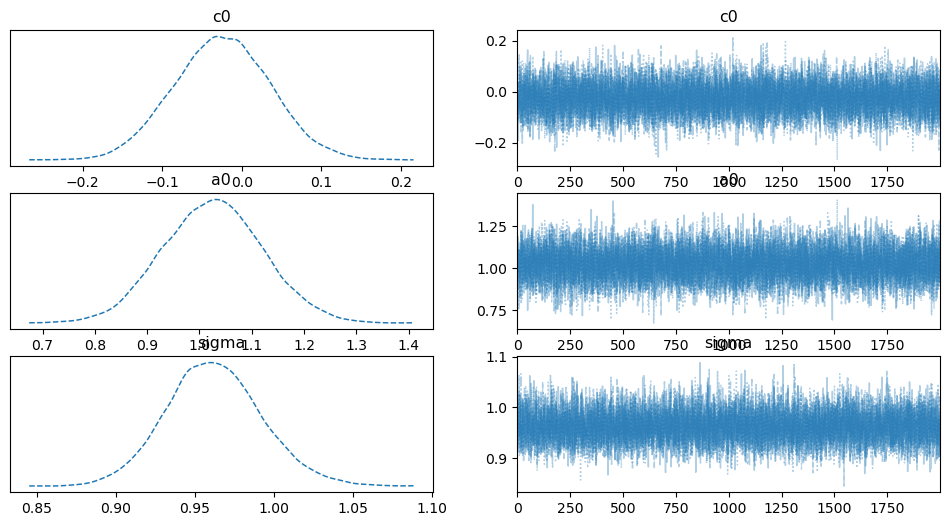

In [14]:
az.plot_trace(traces[0], combined=True);

In [16]:
az.summary(traces[0], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c0,-0.02,0.06,-0.14,0.09,0.0,0.0,11912.62,12108.59,1.0
a0,1.03,0.10,0.86,1.21,0.0,0.0,11603.79,11869.25,1.0
sigma,0.96,0.03,0.90,1.02,0.0,0.0,11810.29,11649.20,1.0


In [30]:
c0[0], a0[0]

(np.float64(-0.02513565483497359), np.float64(1.026516626042362))

In [17]:
az.summary(traces[1], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c0,-1.74,0.21,-2.14,-1.35,0.0,0.0,12082.30,11773.49,1.0
a0,2.72,0.26,2.23,3.19,0.0,0.0,12067.02,11885.87,1.0
sigma,0.96,0.03,0.91,1.02,0.0,0.0,11764.17,11940.26,1.0


In [21]:
traces[1].posterior["c0"].mean().values

array(-1.74317779)

In [29]:
c0[1], a0[1]

(np.float64(-1.743636004010924), np.float64(2.722430765680743))

In [19]:
az.summary(traces[2], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c0,1.07,0.07,0.93,1.20,0.0,0.0,10817.29,12020.26,1.0
a0,-0.72,0.07,-0.85,-0.59,0.0,0.0,12044.44,11549.43,1.0
sigma,0.96,0.03,0.91,1.02,0.0,0.0,12272.51,11901.92,1.0


In [31]:
c0[2], a0[2]

(np.float64(1.06747975346851), np.float64(-0.7192705739146151))

In [20]:
az.summary(traces[3], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c0,0.69,0.05,0.59,0.77,0.0,0.0,11660.41,11658.51,1.0
a0,0.28,0.03,0.23,0.33,0.0,0.0,11409.99,11649.02,1.0
sigma,0.96,0.03,0.90,1.02,0.0,0.0,11868.77,11773.12,1.0


In [22]:
az.summary(traces[4], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c0,0.95,0.06,0.83,1.07,0.0,0.0,11832.51,11460.01,1.0
a0,-0.38,0.04,-0.45,-0.31,0.0,0.0,10873.86,11282.40,1.0
sigma,0.96,0.03,0.91,1.02,0.0,0.0,11434.18,11773.93,1.0


In [23]:
az.summary(traces[5], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c0,1.51,0.11,1.30,1.72,0.0,0.0,12129.66,11855.54,1.0
a0,-0.60,0.06,-0.71,-0.49,0.0,0.0,12088.95,11302.67,1.0
sigma,0.97,0.03,0.91,1.03,0.0,0.0,11926.27,11773.90,1.0


In [24]:
az.summary(traces[6], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c0,0.31,0.05,0.22,0.39,0.0,0.0,11329.17,11561.67,1.0
a0,0.57,0.06,0.46,0.68,0.0,0.0,11624.29,11921.84,1.0
sigma,0.97,0.03,0.91,1.03,0.0,0.0,11846.78,11231.36,1.0


In [25]:
az.summary(traces[7], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c0,1.13,0.08,0.98,1.30,0.0,0.0,12223.23,11633.83,1.0
a0,-1.17,0.12,-1.39,-0.94,0.0,0.0,11976.01,12113.10,1.0
sigma,0.98,0.03,0.92,1.04,0.0,0.0,11760.35,11978.75,1.0


In [26]:
az.summary(traces[8], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c0,0.75,0.06,0.65,0.86,0.0,0.0,11493.88,11977.65,1.0
a0,-0.10,0.01,-0.12,-0.08,0.0,0.0,11845.47,11165.54,1.0
sigma,0.98,0.03,0.92,1.04,0.0,0.0,11648.00,11654.87,1.0


In [27]:
az.summary(traces[9], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c0,0.81,0.06,0.70,0.93,0.0,0.0,11961.02,11640.80,1.0
a0,0.28,0.03,0.22,0.34,0.0,0.0,11397.26,11468.84,1.0
sigma,0.99,0.03,0.93,1.05,0.0,0.0,11421.52,11645.47,1.0
